In [ ]:
from fractions import Fraction
import queue, threading, time, uuid, math, asyncio, os, subprocess, io

import numpy as np
import librosa
from PIL import Image
from IPython.display import display, update_display, Image as IPyImage

import cv2
from stream_pipeline_online import StreamSDK


# --- paths (change these) ---
CFG_PKL  = "./checkpoints/ditto_cfg/v0.4_hubert_cfg_trt_online.pkl"
DATA_ROOT = "./checkpoints/ditto_trt_Ampere_Plus"
AUDIO_PATH  = "static/audio.wav"       # 16 kHz mono WAV / MP3 also OK
SOURCE_PATH = "static/idle.mp4"      # single image or short template video

# StreamSDK instance in online mode
sdk = StreamSDK(CFG_PKL, DATA_ROOT, chunk_size=(3,5,2))
sdk.online_mode = True

audio, _ = librosa.load(AUDIO_PATH, sr=16000)
sdk.setup(SOURCE_PATH)
sdk.start_processing_audio()

<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.nvrtc module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.nvrtc module instead.


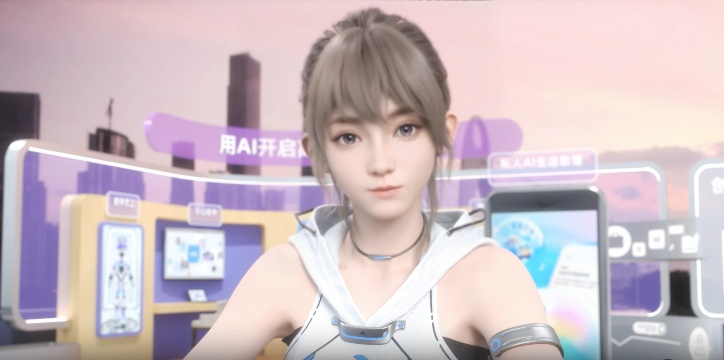

In [3]:
def stream_and_preview(max_fps: float = 80):

    BYTES_PER_FRAME = 640
    present = sdk.chunk_size[1] * BYTES_PER_FRAME
    split_len = int(sum(sdk.chunk_size) * BYTES_PER_FRAME) + 80

    start = 0
    while start < len(audio):
        chunk = audio[start : start + split_len]
        if len(chunk) < split_len:
            chunk = np.pad(chunk, (0, split_len - len(chunk)), mode='constant')
        sdk.process_audio_chunk(chunk)
        start += present

    sdk.end_processing_audio()

    frame_interval = 1.0 / max_fps
    last = time.time()

    handle_id = str(uuid.uuid4())  # display_id to persist the image
    first_display = True

    display_started = False
    while True:
        if not sdk.has_pending_frames() and sdk.frame_queue.qsize() == 0:
            break

        try:
            jpg_bytes, fid, gid = sdk.frame_queue.get(timeout=0.05)
        except queue.Empty:
            continue  # wait for next frame

        img_obj = IPyImage(data=jpg_bytes)
        if not display_started:
            display(img_obj, display_id=handle_id)
            display_started = True
        else:
            update_display(img_obj, display_id=handle_id)

        delta = time.time() - last
        if delta < frame_interval:
            time.sleep(frame_interval - delta)
        last = time.time()
        
    sdk.close()

    
stream_and_preview()

In [1]:
!pip install transformers==4.52.3

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 9.1 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
f5-tts 1.1.5 requires numpy<=1.26.4, but you have numpy 2.0.1 which is incompatible.
